# Analytical determination of $\sigma_0$

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy.special import gamma
import holoviews as hv
from decimal import Decimal
hv.extension('matplotlib')

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
plt.rcParams['font.size']=13
plt.rcParams['font.family']='stix'
plt.rcParams['text.usetex']=True
plt.rcParams['figure.figsize']= (6.5,4)
plt.rcParams['figure.dpi']=150

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Various constants

http://pdg.lbl.gov/2014/reviews/rpp2014-rev-astrophysical-constants.pdf

https://arxiv.org/pdf/1904.10000

https://arxiv.org/pdf/1502.01589.pdf

In [3]:
# Constants
h = 0.6727
H0=67.27
Omega_m = (0.1199)/(h**2)
Omega_b = 0.05
Omega_rad=10e-5
p_crit=4.755e-6
rho_crit = 1.256*10**11*Omega_m
p_b = Omega_b*p_crit
T_0 = 2.7255
kb = 8.617333262145e-5
m_p=0.93827231
Y_p=0.75

# Factors to satisfy units
k_crit_conversionFactor=3.33333333e-6
R_x_conversionFactor=9.258e29

# Mass/sigma arrays
masses = np.array([1e-4,1e-3,1e-2,1e-1,1.,10.])
# masses = np.array([])
# mass = 1e-6
# while(mass<1e3):
#     masses = np.append(masses,mass)
#     mass *= 1.5
sigma = np.zeros(len(masses))
sigma_array = np.logspace(-10,-30,200)

---

## Relevant functions

$ N_0$

https://arxiv.org/pdf/1801.08609.pdf

In [4]:
def N_0(n):
    return pow(2,(5.+n)/2.)*gamma(3.+n/2.)/(3.*np.sqrt(np.pi))

$ M_{hm} \rightarrow k_{hm}$

http://sro.sussex.ac.uk/id/eprint/46339/1/MNRAS-2012-Schneider-684-98.pdf

In [5]:
def mhm2khm(Mhm):
    return 2*np.pi/(13.93*(0.049*(((h*(2.*(((3./4)*Mhm/(np.pi*rho_crit))**(1./3))/13.93)/(0.049*((Omega_m/0.25)**(0.11))*((h/0.7)**1.22)))**(1./-1.11))**(-1.11))*((Omega_m/0.25)**(0.11))*((h/0.7)**1.22)))

#### $ k_{crit} \longleftrightarrow M_{crit} $

https://arxiv.org/pdf/1904.10000

In [6]:
def kcrit2mcrit(k):
    return (4*math.pi/3)*rho_crit*((math.pi/k)**3)

def mcrit2kcrit(M):
    return ((rho_crit*4*(math.pi**4))/(3*M))**(1./3.)

#### $\sigma_0 \longrightarrow R_{\chi} \longrightarrow R'_{\chi} $

https://arxiv.org/pdf/1904.10000

In [7]:
def R_x(sigma_0, m_x, n):
    return N_0(n)*Y_p*p_b*R_x_conversionFactor*(sigma_0/(m_x+m_p))*(pow(((kb*T_0*1e-9)/m_x)+((kb*T_0*1e-9)/m_p),((1.+n)/2.)))

In [8]:
def R_x_prime(sigma_0, m_x, n):
    return (m_x/(m_p+m_x))*R_x(sigma_0,m_x,n)

In [9]:
def R_x2(sigma_0, m_x, n):
    return (1/(N_0(n)*Y_p*p_b*R_x_conversionFactor)*(((m_x+m_p)**2/(sigma_0*m_x))*pow(1/((1/m_x)+(1/m_p))*(1/(kb*T_0*1e-9)),(n+1.)/2.)))

#### $ sigma_0 \longrightarrow z_{th} $

https://arxiv.org/pdf/1904.10000

In [10]:
def z_th(sigma_0,m_x,n):
    return H0*np.sqrt(Omega_rad)*R_x2(sigma_0,m_x,n)**(2./(n+3.))

#### $ sigma_0 \longrightarrow z_{crit} $

https://arxiv.org/pdf/1904.10000

In [11]:
def z_crit(sigma_0,m_x,n):
    return fsolve(lambda z: pow(z,(2*n+4.)/(n+1.)) * (m_p/(1.+z_th(sigma_0,m_x,n)) + (m_x/z)) - (m_x+m_p)*(m_x*m_p/(m_x+m_p))/(kb*T_0*1e-9) * (((H0*np.sqrt(Omega_rad)/(N_0(n)*Y_p*p_b*R_x_conversionFactor))*((m_x+m_p)/sigma_0)))**(2./(n+1.)),z_th(sigma_0,m_x,n)/2.)    

#### $ sigma_0 \longleftrightarrow k_{crit} $

https://arxiv.org/pdf/1904.10000

In [12]:
def sigma2k(sigma_0,m_x,n):
    return 2.*(H0*np.sqrt(Omega_rad)*z_crit(sigma_0,m_x,n))*3.33e-6

def k2sigma(k_crit,m_x,n):
    return fsolve(lambda sigma_0: (2.*(H0*np.sqrt(Omega_rad)*z_crit(sigma_0,m_x,n)**2))/(z_crit(sigma_0,m_x,n) * 3e5) - k_crit,1)

---

## Plotting of cross section vs dark matter mass

In [13]:
def sig(klimit,n):
    sigma = []
    for i in range(len(masses)):
        sigma.append(sigma_array[np.argmin(np.abs(sigma2k(sigma_array,masses[i],n)-h*klimit))])
    return np.array(sigma)

def sigma_vs_mx(klimit):
    return hv.Curve((masses, sig(klimit)))

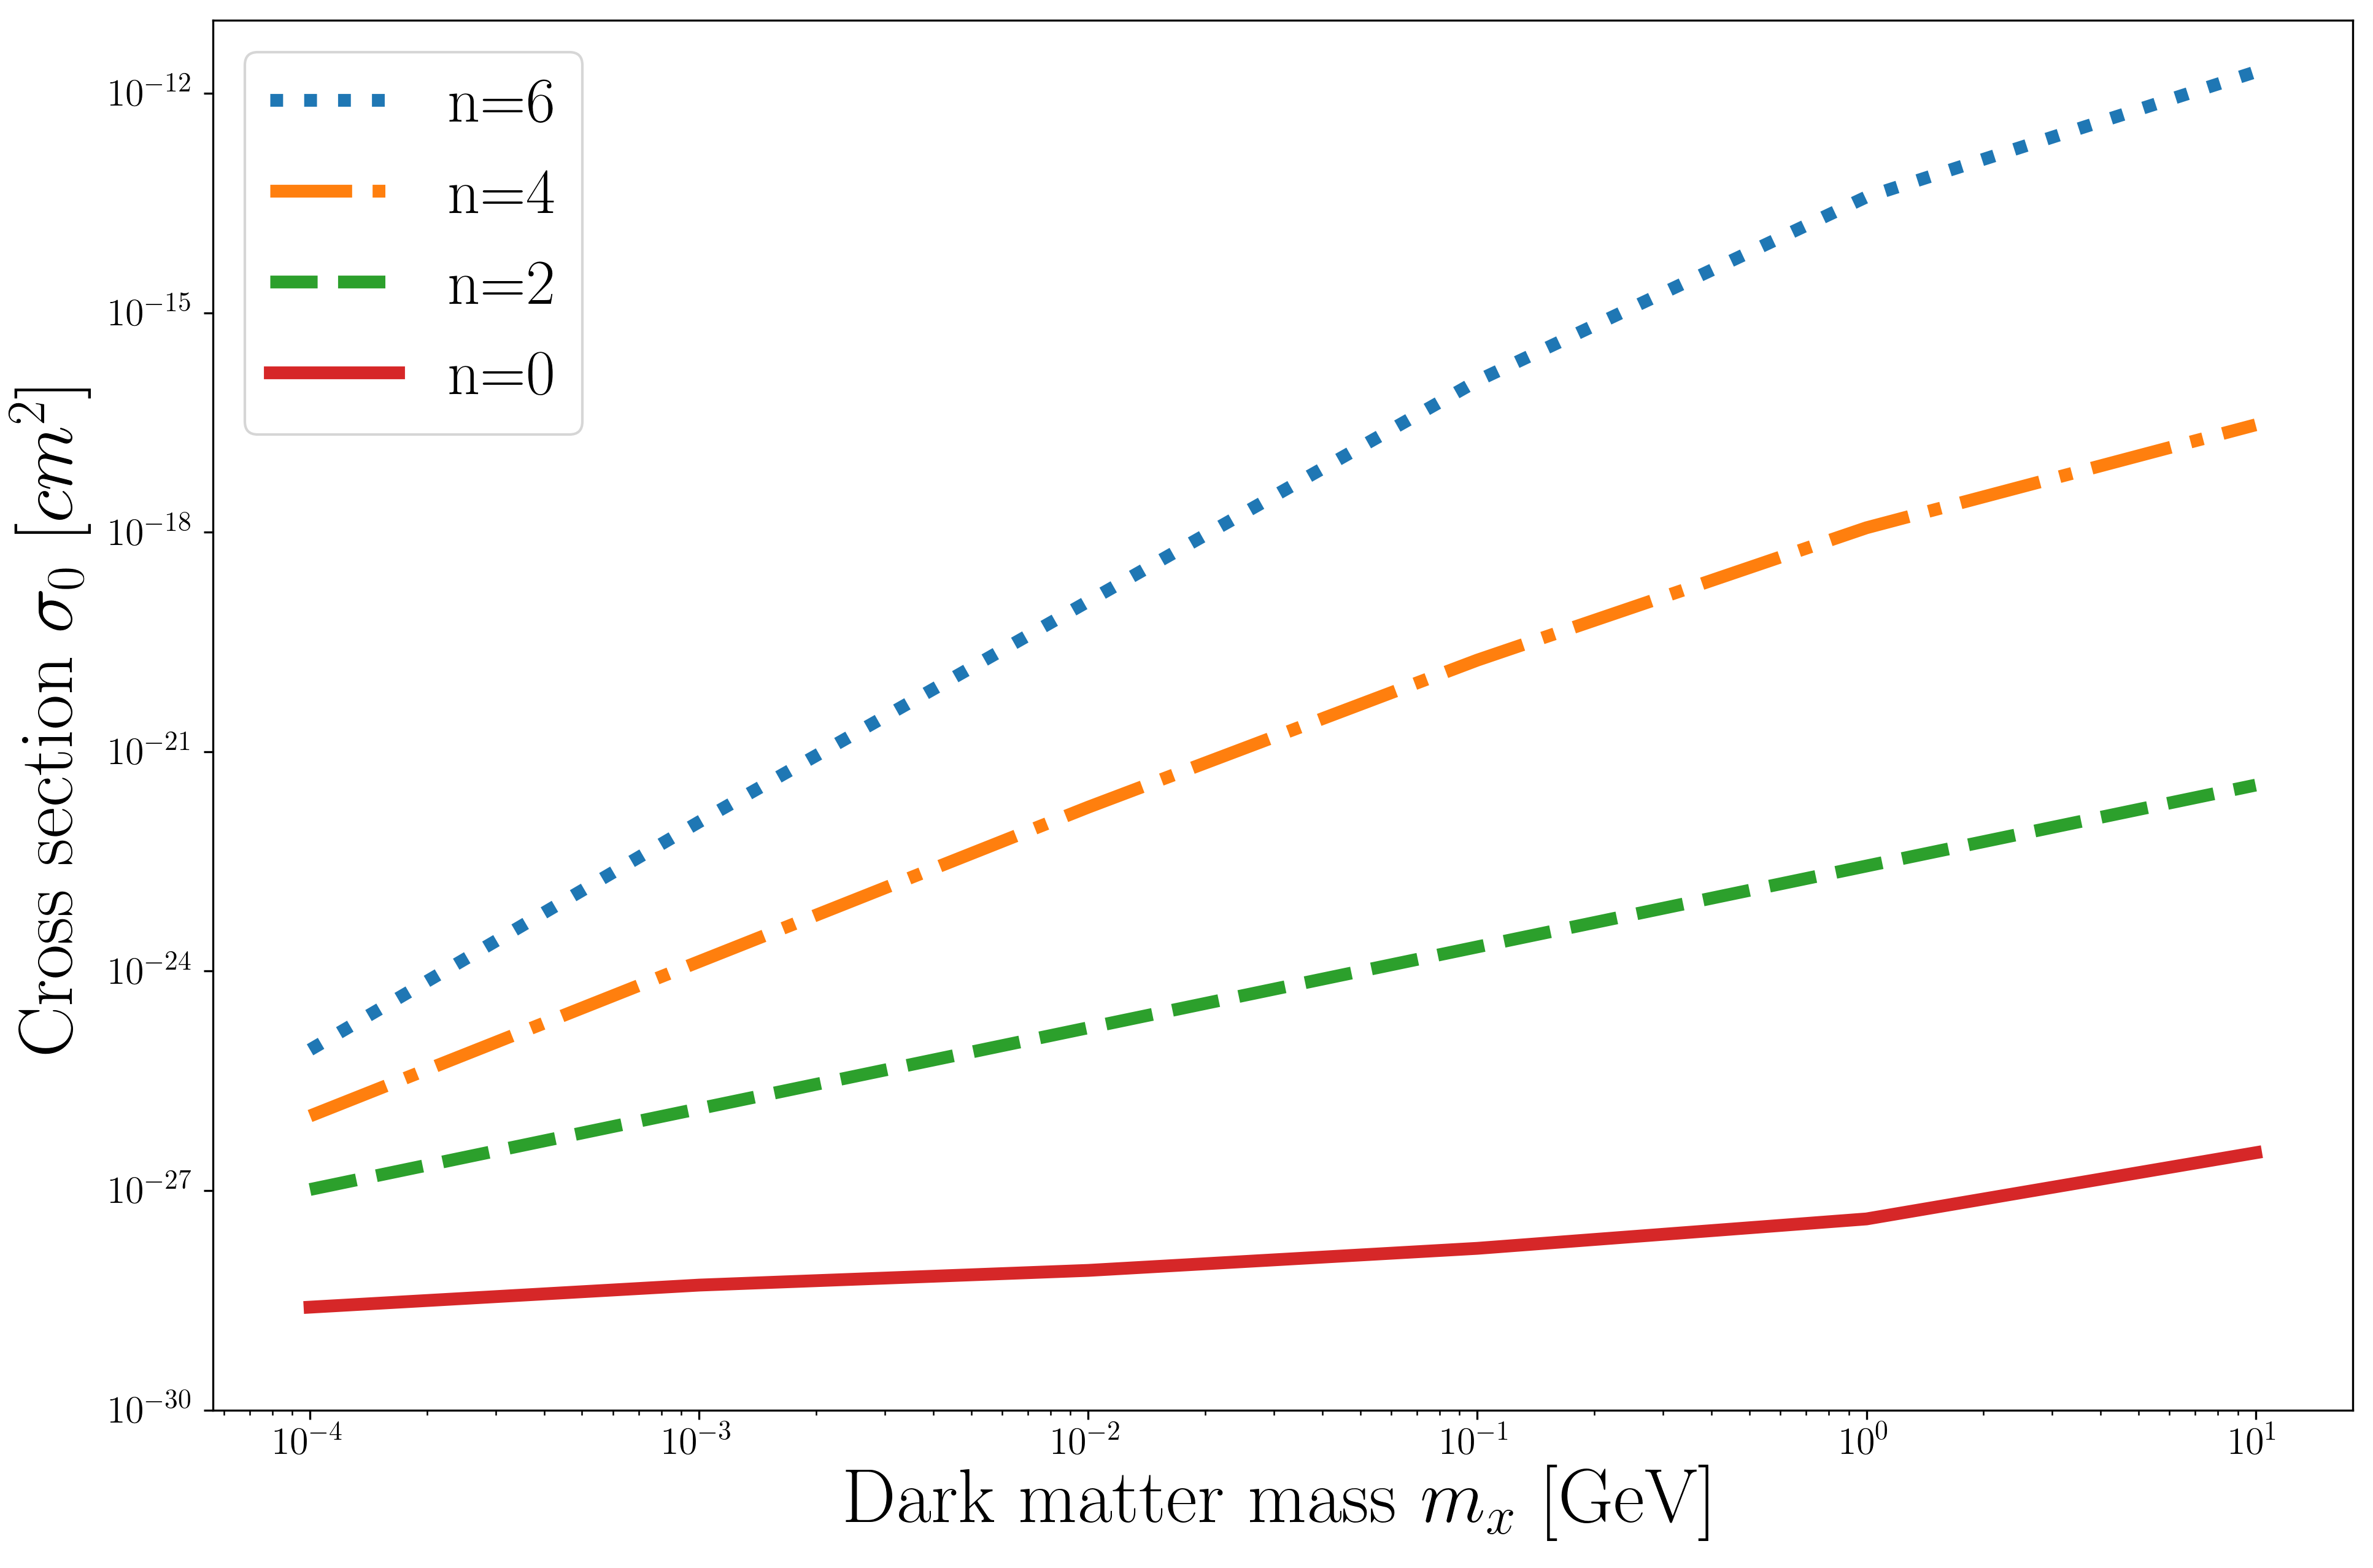

In [22]:
klim = mhm2khm(3*10**8)

plt.figure(figsize=(15,10))

plt.loglog(masses, sig(klim,6.), label="n=6",linewidth=5,linestyle=':')
plt.loglog(masses, sig(klim,4.), label="n=4",linewidth=5,linestyle='-.')
plt.loglog(masses, sig(klim,2.), label="n=2",linewidth=5,linestyle='--')
plt.loglog(masses, sig(klim,0.), label="n=0",linewidth=5)

# plt.title(r"Analytical", fontsize=20)
plt.ylabel(r"Cross section $\sigma_0$ [$cm^2$]", fontsize=30)
plt.xlabel(r"Dark matter mass $m_x$ [GeV]", fontsize=30)
plt.legend(fontsize=25)
plt.tick_params(labelsize=15)
plt.ylim(1e-30,1e-11)

plt.savefig("analytical.png")

Noice

---